In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from PFNExperiments.LinearRegression.GenerativeModels.GenerateDataLM_Examples import make_lm_program_ig_batched, make_lm_program_ig
from PFNExperiments.LinearRegression.GenerativeModels.LM_abstract import return_only_y, print_code
from PFNExperiments.Training.Trainer import visualize_training_results
from PFNExperiments.Training.FlowMatching.CFMLossOTGaussianBase_plus_NLL import CFMLossOTGaussianBase_plus_NLL
from PFNExperiments.LinearRegression.ComparisonModels.Hamiltionion_MC import Hamiltionian_MC
from PFNExperiments.LinearRegression.ComparisonModels.Variational_Inference import Variational_Inference
from PFNExperiments.LinearRegression.Evaluation.CompareComparisonModels import CompareComparisonModels
from PFNExperiments.LinearRegression.GenerativeModels.Curriculum import Curriculum
from PFNExperiments.LinearRegression.GenerativeModels.GenerateDataCurriculumCFM import GenerateDataCurriculumCFM
from PFNExperiments.Training.TrainerCurriculumCNF_LearnedBaseDist_plus_nll import TrainerCurriculumCNF_LearnedBaseDist_plus_nll
from PFNExperiments.LinearRegression.GenerativeModels.GenerateDataLM_Examples import make_lm_program_ig_batched, make_lm_program_ig
from PFNExperiments.LinearRegression.Evaluation.CompareComparisonModels import CompareComparisonModels
from PFNExperiments.LinearRegression.Models.ModelToPosteriorCNF_LearnedBaseDist import ModelToPosteriorCNF_LearnedBaseDist
from PFNExperiments.LinearRegression.Models.Transformer import MLP
from PFNExperiments.LinearRegression.Models.ModelPosterior import ModelPosteriorFullGaussian2
from PFNExperiments.LinearRegression.Models.Transformer_CNF_DoubleCondition2 import TransformerDecoderConditionalDouble_parallel, MLPConditionalDouble_parallel
from PFNExperiments.LinearRegression.Models.Transformer_CNF_LearnedBaseDistribution import TransformerReturnRepresentations, TransformerCNFConditionalDecoderDouble_parallel_learnedBaseDistribution
from PFNExperiments.Evaluation.Evaluate import Evaluate
import pandas as pd

c:\Users\arik_\Documents\Dokumente\Job_Clausthal\PFNs\Repository\PFNExperiments\.conda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
N = 100
P = 10
BATCH_SIZE = 3
N_EPOCHS = 100
N_SAMPLES_PER_EPOCH = 67
N_BATCHES_PER_EPOCH = N_SAMPLES_PER_EPOCH//BATCH_SIZE
SAVE_PATH = "Training/FlowMatching/SaveFolderTesting"

#BATCH_SIZE = 128

In [4]:
a = 5.0
b = 2.0
tau = 1.0

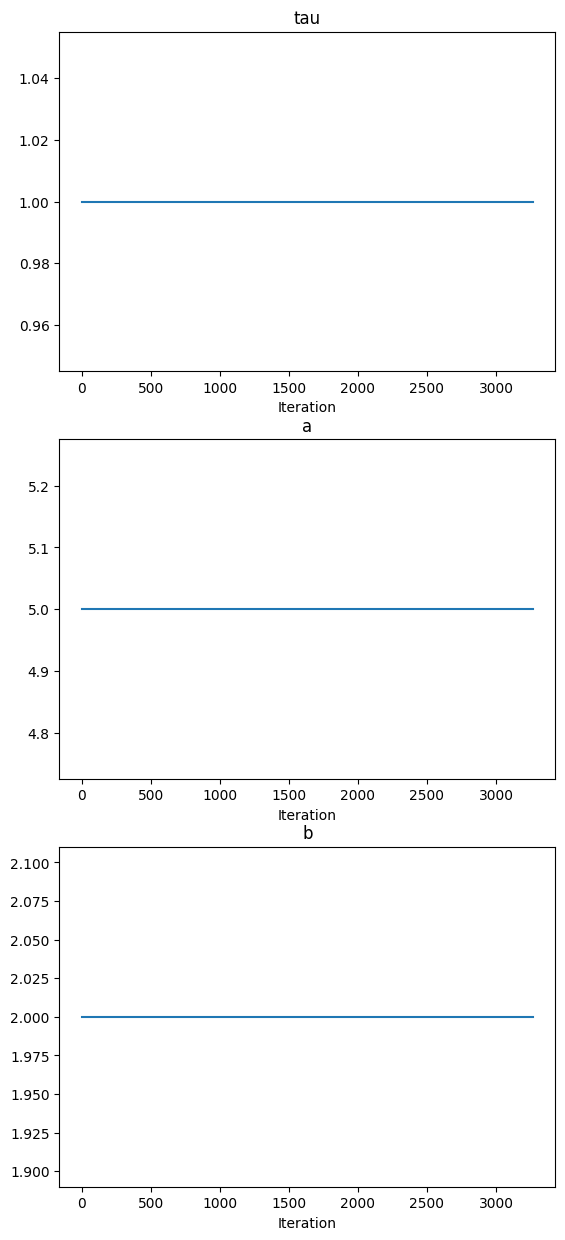

In [5]:
curriculum = Curriculum(max_iter=int(N_EPOCHS*N_BATCHES_PER_EPOCH*BATCH_SIZE*0.5))
curriculum.add_param_list(
    [
    ("tau", curriculum.constant_scheduler(tau)),
    ("a", curriculum.constant_scheduler(a)),
    ("b", curriculum.constant_scheduler(b)),

    ]
)
curriculum.plot_all_schedules()

In [6]:
curriculum.get_params(299*N_SAMPLES_PER_EPOCH)

{'tau': 1.0, 'a': 5.0, 'b': 2.0}

In [7]:
data_generator = GenerateDataCurriculumCFM(
    pprogram_maker= make_lm_program_ig_batched,
    curriculum= curriculum,
    #base_distribution_sampling = GaussianSample,
    #coupling = None
)

In [8]:
"""
data_generator.check_model(
    n_samples_per_epoch=N_SAMPLES_PER_EPOCH,
    epochs_to_check = [0, N_EPOCHS-1],
    p = 5,
    used_batch_samples = 1
)
"""

'\ndata_generator.check_model(\n    n_samples_per_epoch=N_SAMPLES_PER_EPOCH,\n    epochs_to_check = [0, N_EPOCHS-1],\n    p = 5,\n    used_batch_samples = 1\n)\n'

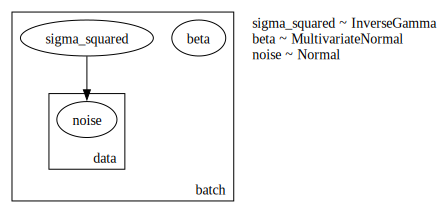

In [9]:
data_generator.render_model()

In [10]:
epoch_loader = data_generator.make_epoch_loader(
    n = N,
    p = P,
    number_of_batches_per_epoch = N_BATCHES_PER_EPOCH,
    n_epochs = N_EPOCHS,
    batch_size= BATCH_SIZE,
    train_frac= 0.5,
    val_frac= 0.1,
    shuffle=False,
    n_samples_to_generate_at_once = 250_000
    )

The number of batches times the number of epochs must be equal to the total number of iterations in the curriculum. But got 6600 and 3300 respectively


In [11]:
sample_batch = next(iter(epoch_loader[0][0]))

In [12]:
sample_batch.keys()

dict_keys(['x', 'y', 'sigma_squared', 'beta', 'time', 'base_sample_beta'])

In [13]:
for key in sample_batch.keys():
    print(key, sample_batch[key].shape)

x torch.Size([3, 100, 10])
y torch.Size([3, 100])
sigma_squared torch.Size([3, 1])
beta torch.Size([3, 10])
time torch.Size([3])
base_sample_beta torch.Size([3, 10])


In [14]:
encoder = TransformerReturnRepresentations(
    n_features= P+1,
    seq_len= N,
    d_model= 512,
    n_heads= 8,
    dim_feedforward=512*2,
    dropout_rate = 0.1,
    n_layers=6,
    n_skip_layers_final_heads = 2,
    n_output_units_per_head=[P, P*P, P]
)

#encoder.load_state_dict(torch.load("C:/Users/arik_/Documents/Dokumente/Job_Clausthal/PFNs/Repository/PFNExperiments/LinearRegression/Models/TestModels/SavedBaseModel/model.pth", map_location=torch.device('cpu')))
# get the correct class to transform model predictions to posterior samples

c:\Users\arik_\Documents\Dokumente\Job_Clausthal\PFNs\Repository\PFNExperiments\.conda\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [15]:
# Initialize the pre-trained encoder model


model_posterior = ModelPosteriorFullGaussian2(cov_reg_factor = 1e-3, use_lowrank_normal = False, diag_transform = lambda x: x**2)

nll_loss = model_posterior.negative_log_likelihood
nll_loss_avg = model_posterior.negative_log_likelihood_avg
nll_loss_std = model_posterior.negative_log_likelihood_std
nll_loss_median = model_posterior.negative_log_likelihood_median

mlp_to_process_encoder_output = MLP(
    n_input_units = encoder.d_model,
    n_output_units= 1024,
    n_hidden_units= 1024,
    n_skip_layers= 3,
    dropout_rate = 0.1
)

mlp_to_process_time_conditioning = MLP(
    n_input_units = 1,
    n_output_units = 64,
    n_hidden_units= 64,
    n_skip_layers= 2,
    dropout_rate = 0.1
)
decoder = TransformerDecoderConditionalDouble_parallel(
    n_input_features= P,
    d_model_decoder= 256,
    d_model_encoder= encoder.d_model,
    n_heads= 8,
    d_ff = 256*2,
    dropout= 0.1,
    n_condition_features_a = mlp_to_process_encoder_output.n_output_units,
    n_condition_features_b = mlp_to_process_time_conditioning.n_output_units,
    n_layers= 1,
    use_positional_encoding=False,
    use_self_attention=False,
)
mlp_to_process_decoder_output = MLPConditionalDouble_parallel(
    n_input_units= decoder.d_model_decoder,
    n_output_units = P,
    n_hidden_units = 256, 
    n_skip_layers = 2,
    dropout_rate = 0.1,
    n_condition_features_a = mlp_to_process_encoder_output.n_output_units,
    n_condition_features_b = mlp_to_process_time_conditioning.n_output_units
)
model = TransformerCNFConditionalDecoderDouble_parallel_learnedBaseDistribution(
    encoder = encoder,
    model_posterior = model_posterior,
    mlp_to_process_encoder_output = mlp_to_process_encoder_output,
    mlp_to_process_time_conditioning = mlp_to_process_time_conditioning,
    mlp_to_process_decoder_output = mlp_to_process_decoder_output,
    decoder = decoder,
    freeze_encoder=False,
)

In [16]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [17]:
'{:.2e}'.format(count_parameters(model))

'4.67e+07'

In [18]:
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR

In [19]:
lr = 1e-4
opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

In [20]:
loss_fun = CFMLossOTGaussianBase_plus_NLL(
    weight_nll = 0.5,
    NLL_Loss_function= nll_loss,
    sigma_min=1e-3,
    return_sub_losses=True
)

In [21]:
scheduler = OneCycleLR(opt,
                       max_lr = 1e-4,
                       epochs = N_EPOCHS,
                       steps_per_epoch = N_SAMPLES_PER_EPOCH//BATCH_SIZE,
                       pct_start = 0.1,
                       div_factor=25.0,
                       final_div_factor=1e2)

scheduler = ReduceLROnPlateau(opt)

additional_evals = {
    nll_loss_avg,
    nll_loss_std,
    nll_loss_median
    
}

In [22]:
trainer = TrainerCurriculumCNF_LearnedBaseDist_plus_nll(
    model = model,
    optimizer=opt,
    scheduler = None,
    loss_function=loss_fun,
    epoch_loader = epoch_loader,
    evaluation_functions= additional_evals,
    n_epochs = N_EPOCHS,
    early_stopping_patience = 200,
    schedule_step_on = "batch",
    save_path = SAVE_PATH,
    use_same_timestep_per_batch = False,
    using_OTLossGaussianBase = True,
    sub_losses_names = ["loss_FM", "loss_NLL"]
    
)

In [23]:
trainer.save_path

'Training/FlowMatching/SaveFolderTesting/experiment_2024_07_14_17_26_24'

In [24]:
model = trainer.model

In [25]:
model.eval()

TransformerCNFConditionalDecoderDouble_parallel_learnedBaseDistribution(
  (encoder): TransformerReturnRepresentations(
    (mlp1): PositionwiseFeedForward(
      (w_1): Linear(in_features=11, out_features=261, bias=True)
      (w_2): Linear(in_features=261, out_features=512, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (act1): LeakyReLU(negative_slope=0.01)
    (encoder_layer): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
      )
      (linear1): Linear(in_features=512, out_features=1024, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=1024, out_features=512, bias=True)
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
  

In [26]:
full_model = ModelToPosteriorCNF_LearnedBaseDist(
    model = trainer.model,
    sample_name = "beta",
    sample_shape = (P,),
    n_samples=100,
    solve_adjoint = True,
    sample_only_base_dist = True,
    atol=100,
    rtol=100
)

In [27]:
benchmark_params_ppgrogram = data_generator.curriculum.get_params(-1)
print(f"params for pprogram: {benchmark_params_ppgrogram}")

pprogram1 = make_lm_program_ig(**benchmark_params_ppgrogram)

pprogram1_y = return_only_y(pprogram1)
print_code(pprogram1)

params for pprogram: {'tau': 1.0, 'a': 5.0, 'b': 2.0}
        def multivariate_lm_return_dict(x: torch.Tensor, y: torch.Tensor = None) -> dict:
                # Define distributions for the global parameters
                sigma_squared_dist = dist.InverseGamma(a, b)

                beta_cov = torch.eye(x.shape[1]) * (tau ** 2)  # the covariance matrix of the parameters of the linear model

                sigma_squared = pyro.sample("sigma_squared", sigma_squared_dist).squeeze()

                beta_dist = dist.MultivariateNormal(torch.zeros(x.shape[1]), beta_cov)
                beta = pyro.sample("beta", beta_dist)

                # Compute mean using matrix multiplication
                mean = torch.matmul(x, beta)

                with pyro.plate("data", len(x)):
                        y = pyro.sample("obs", pyro.distributions.Normal(mean, sigma_squared), obs=y)


                return {
                        "x": x,
                        "y": y,
                      

In [28]:
test_loader = trainer.testset

In [29]:
hmc_sampler = Hamiltionian_MC(pprogram = pprogram1_y, n_warmup=10, n_samples=50)

vi = Variational_Inference(
    pprogram=pprogram1,
    guide = None,
    n_steps = 20,
    n_samples=50,
    lr = 1e-2
)

In [31]:
evaluation = Evaluate(
    posterior_model = full_model,
    evaluation_loader= test_loader,
    comparison_models= [hmc_sampler, vi],
    n_evaluation_cases=11,
    save_path= "C:/users/arik_/Documents/Dokumente/Job_Clausthal/PFNs/Repository/PFNExperiments/Training/FlowMatching/SaveFolderTesting",
    overwrite_results= True
)

The save path is not empty and the overwrite flag is set, the results will be overwritten


In [32]:
evaluation.run_evaluation()

Sampling posterior:   0%|          | 0/11 [00:00<?, ?it/s]

.


Sampling posterior:   9%|▉         | 1/11 [00:00<00:02,  3.70it/s]

.


Sampling posterior:  18%|█▊        | 2/11 [00:00<00:02,  3.78it/s]

.


Sampling posterior:  27%|██▋       | 3/11 [00:00<00:02,  3.91it/s]

.


Sampling posterior:  36%|███▋      | 4/11 [00:01<00:01,  3.90it/s]

.


Sampling posterior:  45%|████▌     | 5/11 [00:01<00:01,  3.74it/s]

.

Sampling posterior:  55%|█████▍    | 6/11 [00:01<00:01,  3.13it/s]


.

Sampling posterior:  64%|██████▎   | 7/11 [00:02<00:01,  3.05it/s]


.

Sampling posterior:  73%|███████▎  | 8/11 [00:02<00:00,  3.07it/s]


.

Sampling posterior:  82%|████████▏ | 9/11 [00:02<00:00,  3.03it/s]


.

Sampling posterior:  91%|█████████ | 10/11 [00:03<00:00,  3.14it/s]


.

Sampling posterior: 100%|██████████| 11/11 [00:03<00:00,  3.30it/s]


100%|██████████| 100/100 [03:11<00:00,  1.91s/it]


Comparison to ground truth:

Summarized results:


,Model,GT,Mean_joint_Wasserstein_distance with metric euclidean,Mean_joint_MMD,Mean_joint_CST_accuracy,Mean_joint_CST_roc_auc_score,Mean_gt_parameter_Perplextiy,Mean_gt_parameter_MAP diff,Mean_gt_parameter_Mean diff,Std_joint_Wasserstein_distance with metric euclidean,Std_joint_MMD,Std_joint_CST_accuracy,Std_joint_CST_roc_auc_score,Std_gt_parameter_Perplextiy,Std_gt_parameter_MAP diff,Std_gt_parameter_Mean diff
0,ModelToPosteriorCNF_LearnedBaseDist,gt,20.688902,0.397793,0.393939,0.409091,-622.938477,0.821634,0.828994,0.009424,0.000341,0.113596,0.117406,355.410601,0.156221,0.150809
1,Hamiltonian Monte Carlo,gt,20.869762,0.402089,0.422727,0.434091,-150.356732,0.149719,0.141061,0.011453,0.000532,0.089837,0.097643,424.514330,0.070963,0.047872
2,Variational Inference with guide: AutoDiagonal...,gt,20.680393,0.397198,0.407576,0.413636,-1113.518247,0.812474,0.817250,0.003416,0.000180,0.086719,0.095108,493.162579,0.143400,0.146238


P-values:


,Model 1,Model 2,joint_Wasserstein_distance with metric euclidean_p-value,joint_MMD_p-value,joint_CST_accuracy_p-value,joint_CST_roc_auc_score_p-value,gt_parameter_Perplextiy_p-value,gt_parameter_MAP diff_p-value,gt_parameter_Mean diff_p-value
0,ModelToPosteriorCNF_LearnedBaseDist,Hamiltonian Monte Carlo,0.000977,0.000977,0.700195,0.764648,0.041992,0.000977,0.000977
1,ModelToPosteriorCNF_LearnedBaseDist,Variational Inference with guide: AutoDiagonal...,0.026231,0.004439,0.385653,0.503612,0.012792,0.929153,0.154860
2,Hamiltonian Monte Carlo,Variational Inference with guide: AutoDiagonal...,0.000977,0.000977,0.831055,0.700195,0.006836,0.000977,0.000977



Comparison among models:

Summarized results:


,Model 1,Model 2,Mean_Wasserstein_distance with metric euclidean,Mean_MMD,Mean_CST_accuracy,Mean_CST_roc_auc_score,Std_Wasserstein_distance with metric euclidean,Std_MMD,Std_CST_accuracy,Std_CST_roc_auc_score
0,ModelToPosteriorCNF_LearnedBaseDist,Hamiltonian Monte Carlo,3.240344,6.260021,1.000000,1.000000,0.510454,0.441811,0.00000,0.00000
1,ModelToPosteriorCNF_LearnedBaseDist,Variational Inference with guide: AutoDiagonal...,0.636555,1.305736,0.936364,0.936364,0.099208,0.461610,0.04081,0.04081
2,Hamiltonian Monte Carlo,Variational Inference with guide: AutoDiagonal...,3.170470,6.775904,1.000000,1.000000,0.515781,0.381667,0.00000,0.00000


P-values:


,Pair 1: Model A,Pair 1: Model B,Pair 2: Model A,Pair 2: Model B,Wasserstein_distance with metric euclidean_p-value,MMD_p-value,CST_accuracy_p-value,CST_roc_auc_score_p-value
0,ModelToPosteriorCNF_LearnedBaseDist,Hamiltonian Monte Carlo,ModelToPosteriorCNF_LearnedBaseDist,Variational Inference with guide: AutoDiagonal...,0.000082,0.000082,0.000092,0.000092
1,ModelToPosteriorCNF_LearnedBaseDist,Hamiltonian Monte Carlo,Hamiltonian Monte Carlo,Variational Inference with guide: AutoDiagonal...,0.792813,0.010439,1.000000,1.000000
2,ModelToPosteriorCNF_LearnedBaseDist,Variational Inference with guide: AutoDiagonal...,Hamiltonian Monte Carlo,Variational Inference with guide: AutoDiagonal...,0.000082,0.000082,0.000092,0.000092


{'summarized_results': {'comparison_to_gt':                                                Model  GT  \
  0                ModelToPosteriorCNF_LearnedBaseDist  gt   
  1                            Hamiltonian Monte Carlo  gt   
  2  Variational Inference with guide: AutoDiagonal...  gt   
  
     Mean_joint_Wasserstein_distance with metric euclidean  Mean_joint_MMD  \
  0                                          20.688902            0.397793   
  1                                          20.869762            0.402089   
  2                                          20.680393            0.397198   
  
     Mean_joint_CST_accuracy  Mean_joint_CST_roc_auc_score  \
  0                 0.393939                      0.409091   
  1                 0.422727                      0.434091   
  2                 0.407576                      0.413636   
  
     Mean_gt_parameter_Perplextiy  Mean_gt_parameter_MAP diff  \
  0                   -622.938477                    0.821634   
  1        

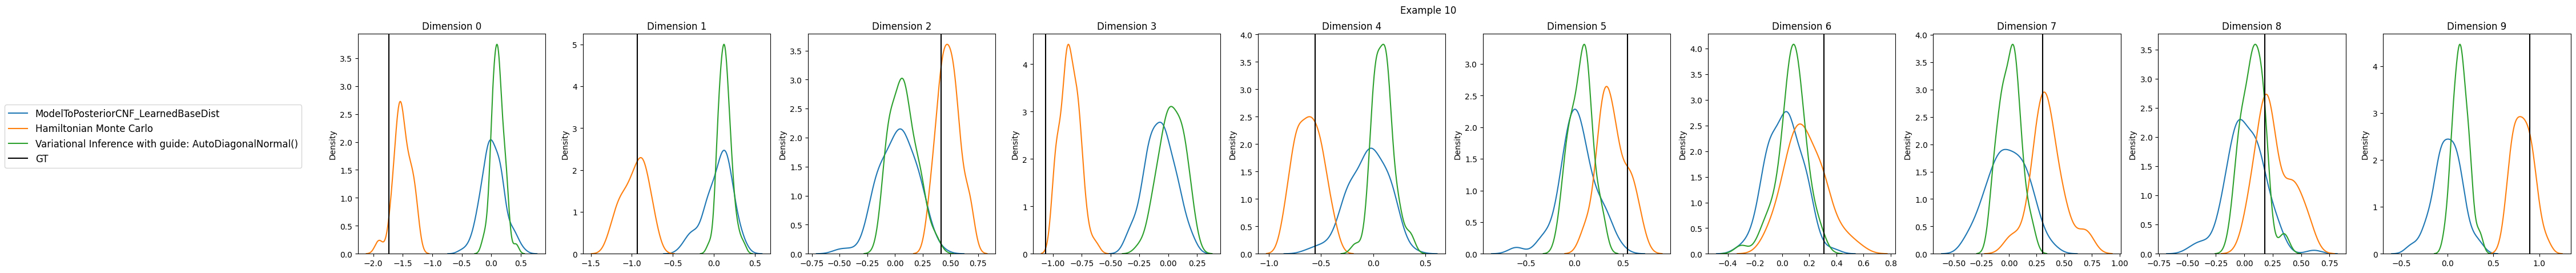

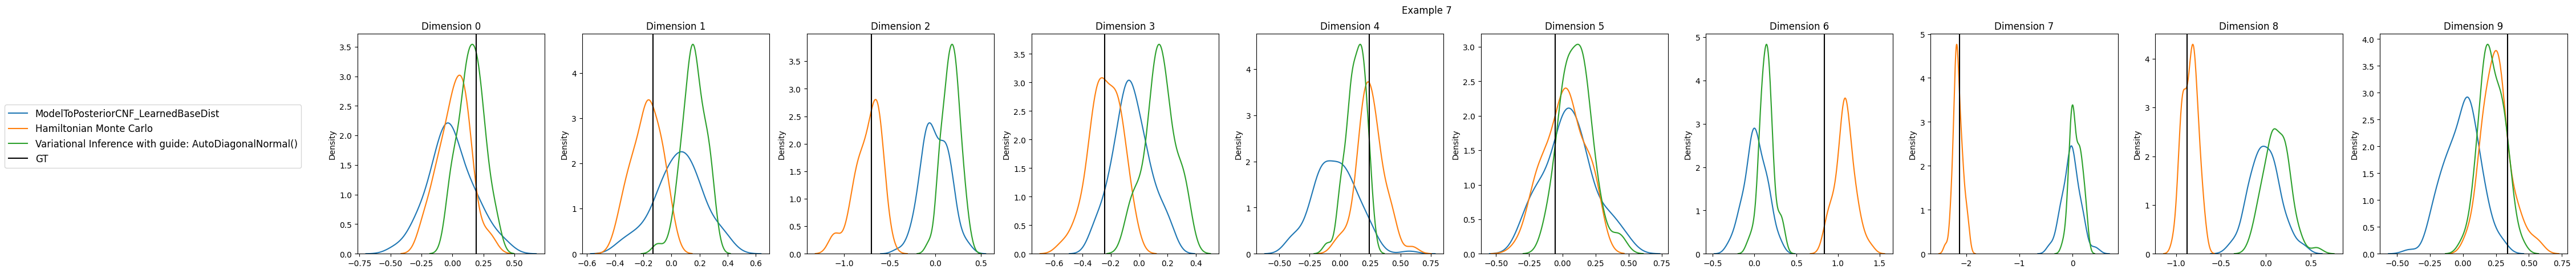

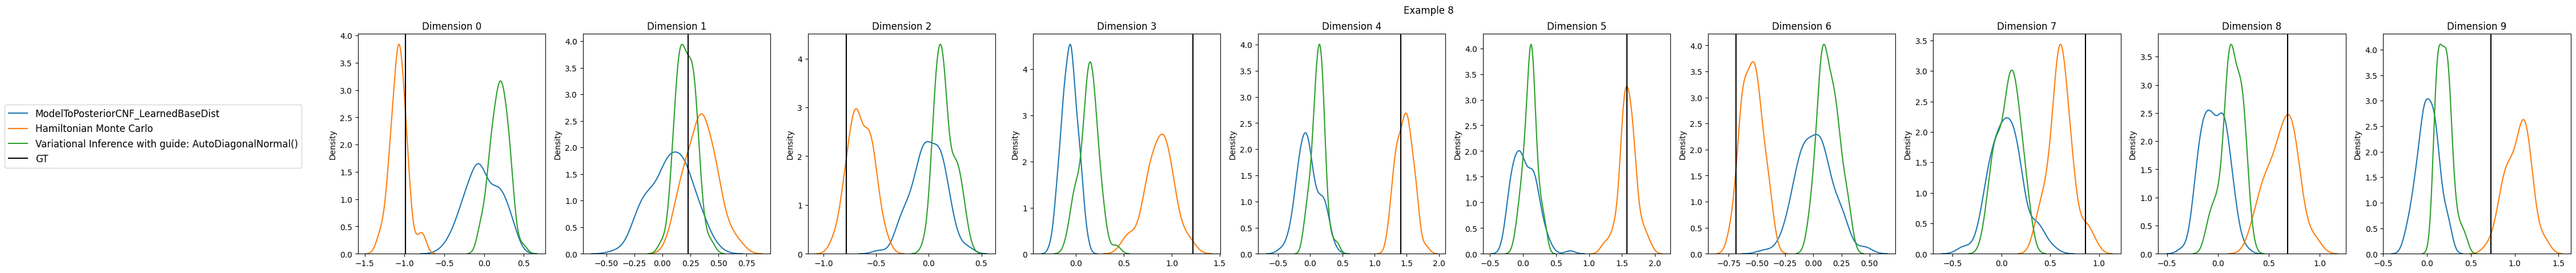

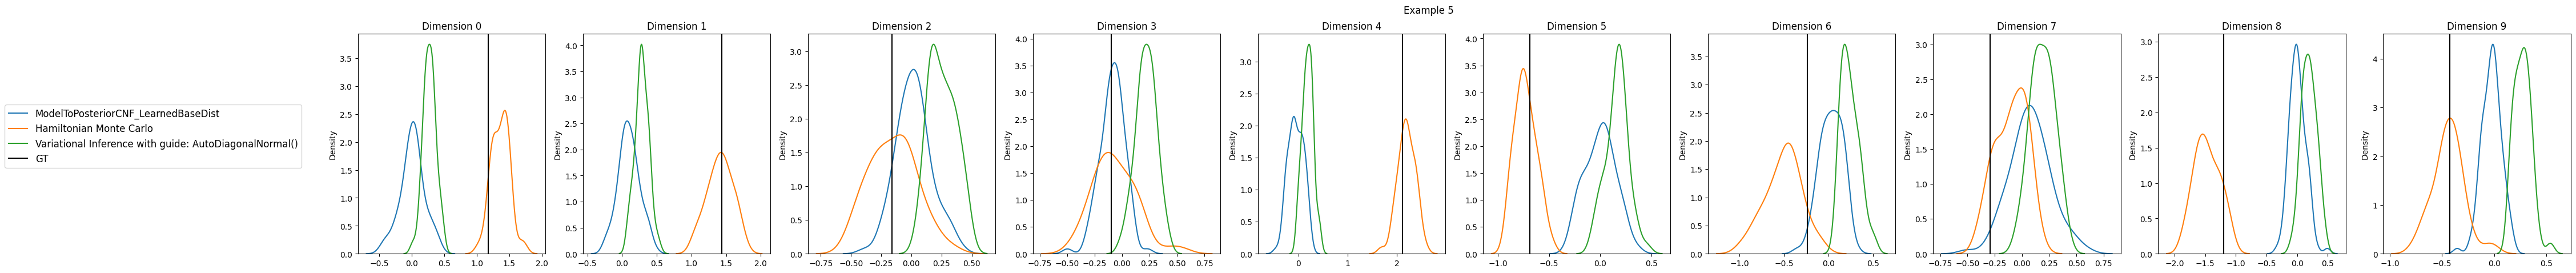

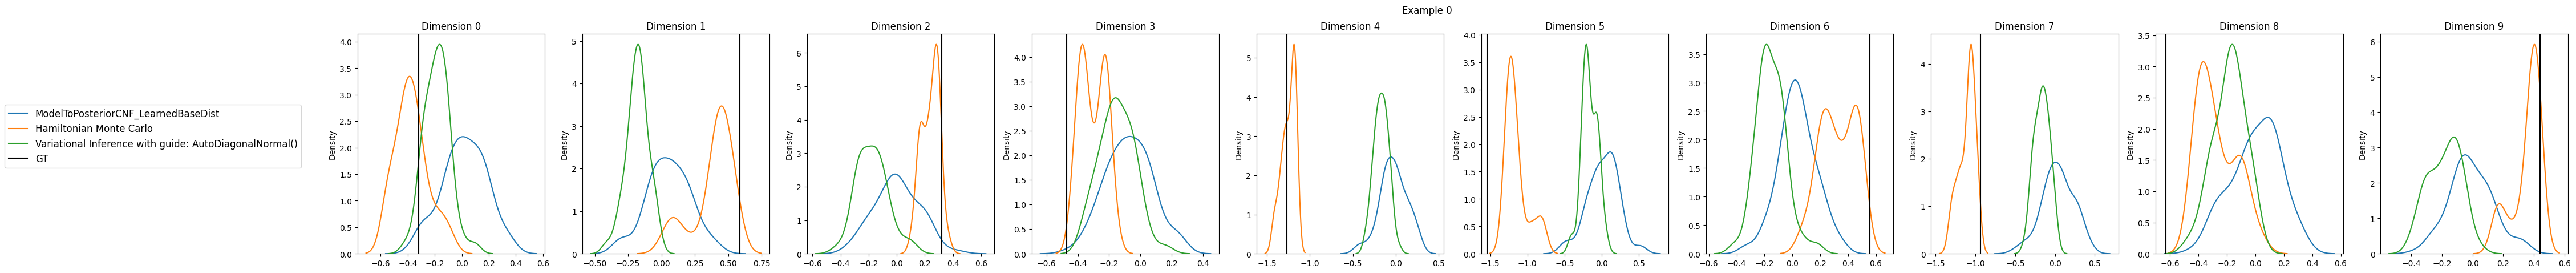

In [34]:
evaluation.plot_results()

In [31]:
r  = evaluation._run_eval_raw_results()

Sampling posterior:   8%|▊         | 1/12 [00:00<00:02,  3.80it/s]

.
.

Sampling posterior:  17%|█▋        | 2/12 [00:00<00:02,  4.70it/s]


.


Sampling posterior:  33%|███▎      | 4/12 [00:00<00:01,  5.27it/s]

.
.

Sampling posterior:  42%|████▏     | 5/12 [00:00<00:01,  5.47it/s]


.


Sampling posterior:  58%|█████▊    | 7/12 [00:01<00:00,  5.57it/s]

.
.

Sampling posterior:  67%|██████▋   | 8/12 [00:01<00:00,  5.62it/s]


.


Sampling posterior:  75%|███████▌  | 9/12 [00:01<00:00,  5.67it/s]

.


Sampling posterior:  83%|████████▎ | 10/12 [00:01<00:00,  4.99it/s]

.

Sampling posterior:  92%|█████████▏| 11/12 [00:02<00:00,  4.00it/s]


.

Sampling posterior: 100%|██████████| 12/12 [00:02<00:00,  4.65it/s]


100%|██████████| 100/100 [03:07<00:00,  1.87s/it]


In [32]:
r0 = r[0]

In [33]:
r[1].keys()

dict_keys(['posterior_model_vs_gt', 'comparison_models_vs_gt', 'posterior_model_vs_comparison_models', 'comparison_models_vs_comparison_models'])

In [61]:
r[1]["posterior_model_vs_gt"]

{('ModelToPosteriorCNF_LearnedBaseDist',
  'gt'): {'joint': [{'joint_Wasserstein_distance with metric euclidean': 21.224882125854492,
    'joint_MMD': 0.3782186508178711,
    'joint_CST_accuracy': 0.6000000238418579,
    'joint_CST_roc_auc_score': 0.6},
   {'joint_Wasserstein_distance with metric euclidean': 21.18008041381836,
    'joint_MMD': 0.37731266021728516,
    'joint_CST_accuracy': 0.5666667222976685,
    'joint_CST_roc_auc_score': 0.6},
   {'joint_Wasserstein_distance with metric euclidean': 21.18785285949707,
    'joint_MMD': 0.37701988220214844,
    'joint_CST_accuracy': 0.4333333373069763,
    'joint_CST_roc_auc_score': 0.425},
   {'joint_Wasserstein_distance with metric euclidean': 21.1900577545166,
    'joint_MMD': 0.3771054744720459,
    'joint_CST_accuracy': 0.550000011920929,
    'joint_CST_roc_auc_score': 0.575},
   {'joint_Wasserstein_distance with metric euclidean': 21.198999404907227,
    'joint_MMD': 0.3771202564239502,
    'joint_CST_accuracy': 0.6000000238418579

In [106]:
r2 = evaluation.summarize_results(r0)

In [107]:
r_tests = evaluation.run_tests(r0)

In [108]:
r_tests["comparison_to_gt"]

,Model 1,Model 2,joint_Wasserstein_distance with metric euclidean_p-value,joint_MMD_p-value,joint_CST_accuracy_p-value,joint_CST_roc_auc_score_p-value,gt_parameter_Perplextiy_p-value,gt_parameter_MAP diff_p-value,gt_parameter_Mean diff_p-value
0,ModelToPosteriorCNF_LearnedBaseDist,Hamiltonian Monte Carlo,0.000488,0.003418,0.077148,0.077148,0.000488,0.000488,0.000488
1,ModelToPosteriorCNF_LearnedBaseDist,Variational Inference with guide: AutoDiagonal...,0.015022,0.012063,0.255158,0.261883,0.059739,0.307821,0.157939
2,Hamiltonian Monte Carlo,Variational Inference with guide: AutoDiagonal...,0.000488,0.266113,0.020996,0.012207,0.000488,0.000488,0.000488


In [ ]:
evaluation.run_evaluation()

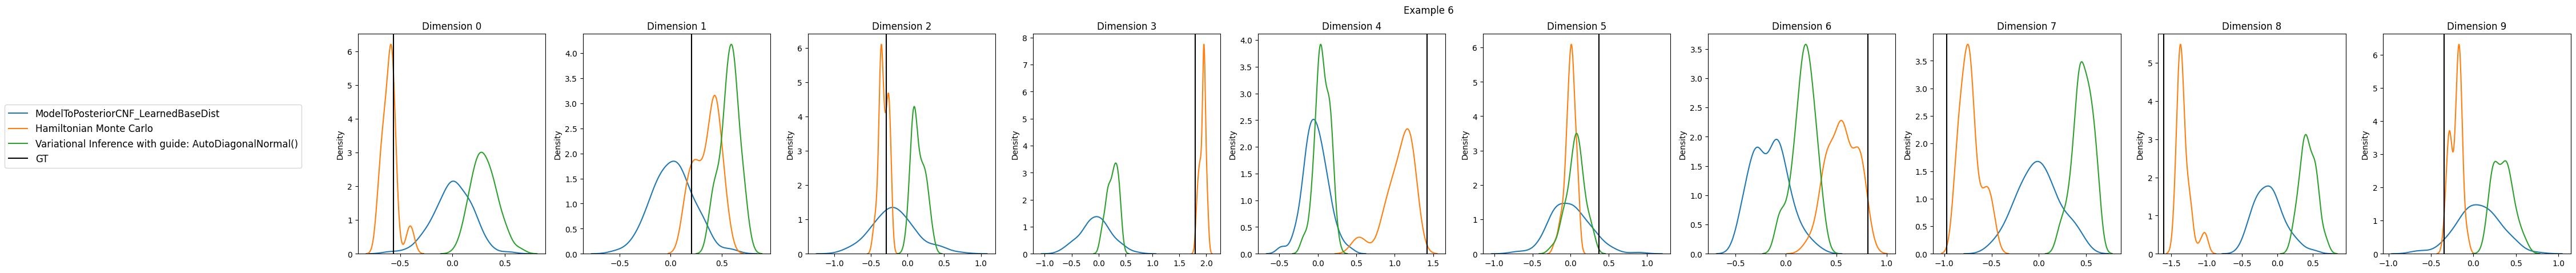

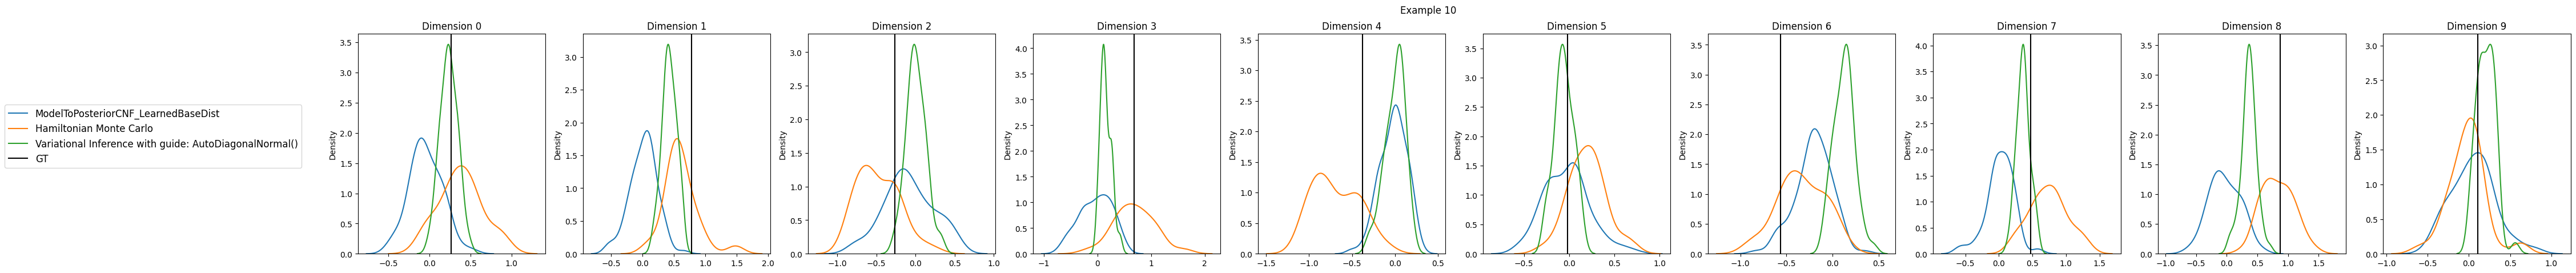

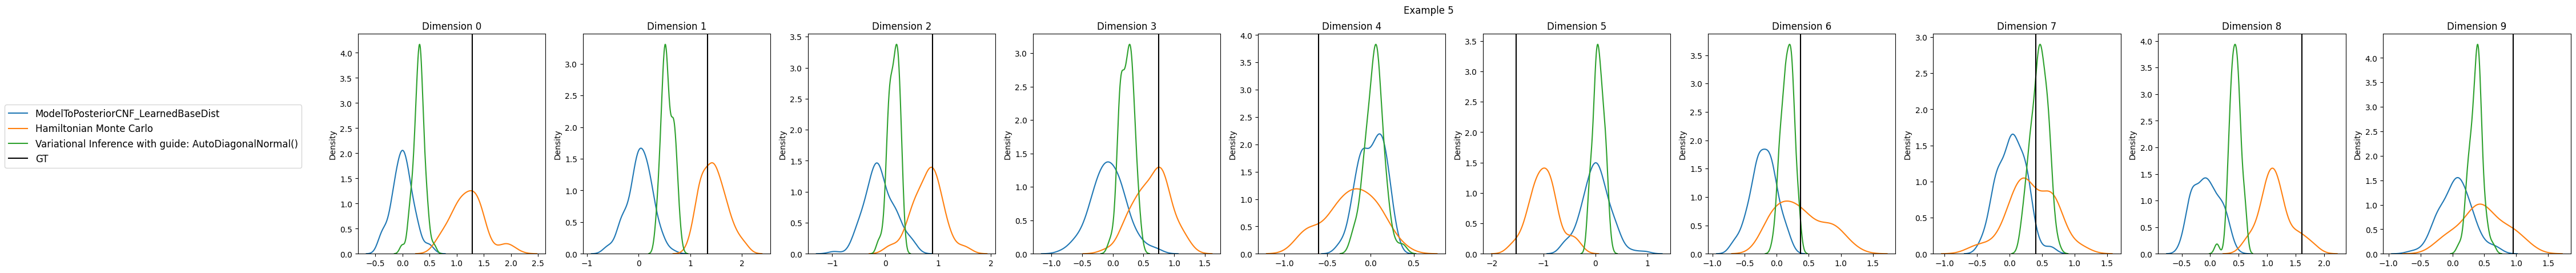

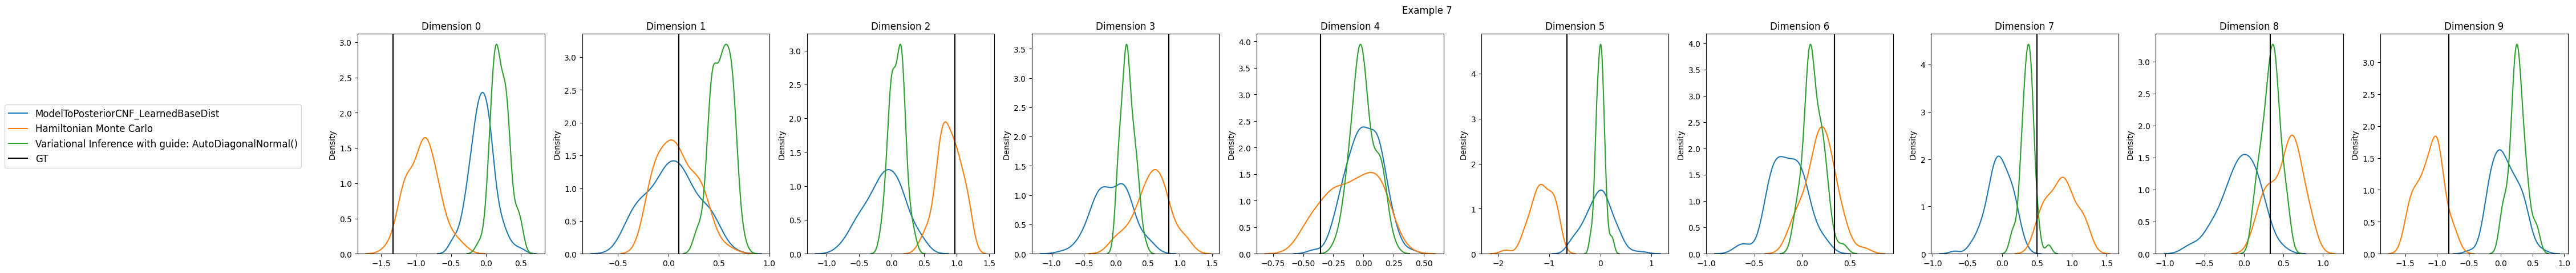

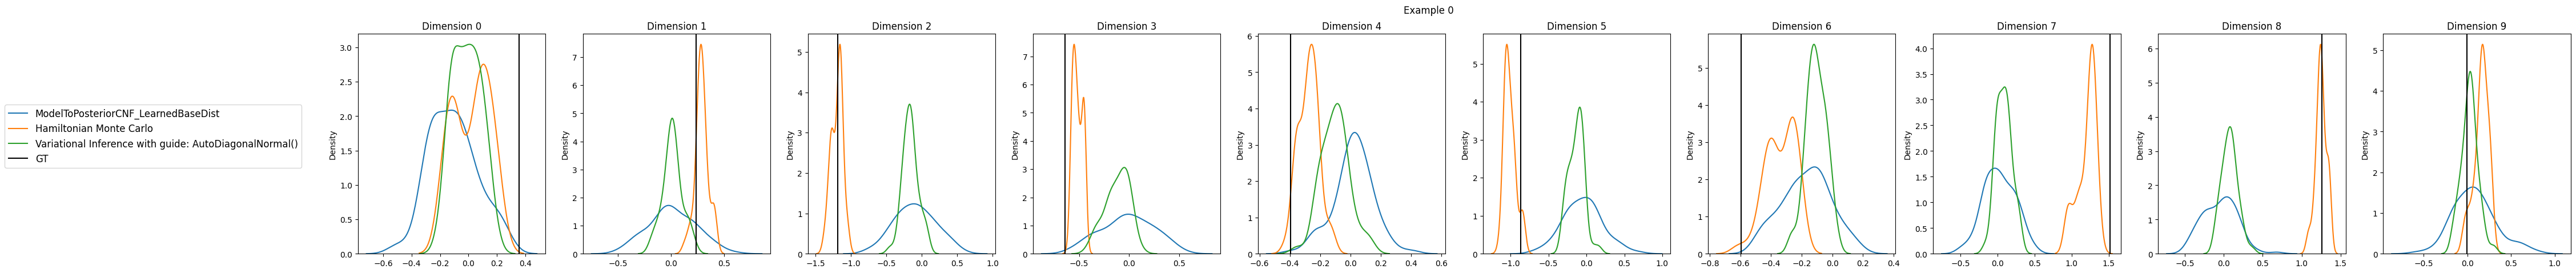

In [121]:
evaluation.plot_results()